<a href="https://colab.research.google.com/github/yaobviously/sym-cargo/blob/main/sym_cargo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install plotly-express --quiet
!pip install vincenty --quiet

I'll clean up this repo and provide visualizations. 

I used many quick plots to figure out heuristics to exclude ships travelling near ports with no intention of docking, but I excluded them from his notebook because it was messy. I'll clean up a few and put them in.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, RepeatVector, LSTM, Dense, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from vincenty import vincenty
from sklearn.model_selection import train_test_split
import plotly_express as px

In [6]:
port_file = '/content/drive/MyDrive/Ports/ports.csv'
tracking_file = '/content/drive/MyDrive/Ports/tracking.csv'

In [7]:
def wrangle():
  
  df1 = pd.read_csv(port_file)

  # converting lat and long to radians to compute haversine distance
  df1['lat_rad'] = np.radians(df1['lat'])
  df1['long_rad'] = np.radians(df1['long'])
  
  # rounding lat and long in port df
  df1['lat'] = df1['lat']
  df1['long'] = df1['long']

  df2 = pd.read_csv(tracking_file, parse_dates=['datetime'])
  df2 = df2.drop_duplicates()
  df2 = df2.sort_values(['vessel', 'datetime'])
  df2['vessel_1back'] = df2['vessel'].shift()
  
  # converting lat and long to radians to compute haversine distance  
  df2['lat_rad'] = np.radians(df2['lat'])
  df2['long_rad'] = np.radians(df2['long'])

  # adding lat/long column and lat/long 1 back to later compute delta
  df2['lat_long'] = [[x,y] for x, y in zip(df2['lat'], df2['long'])]
  df2['lat_long_1back'] = df2.groupby('vessel')['lat_long'].transform(lambda x: x.shift())
  
  # time deltas to compute impossible distances travelled
  df2['time_delta'] = df2.groupby('vessel')['datetime'].transform(lambda x: x - x.shift(1))
  df2['hour_delta'] = [(n.days * 24) + (n.seconds / 3600) for n in df2['time_delta']]

  # filtering using query to eliminate unneeded/impossible values
  df2 = df2.query('speed <30 & heading <=360 & draft < 13.5')
  df2 = df2.reset_index(drop=True)

  return df1, df2

In [8]:
df1, df2 = wrangle()

In [9]:
def vincent_distance(row):
  """ 
  returns the vincenty distance for contiguous rows - will be used to identify
  impossible distances travelled, and so on. could be used to create distance
  matrix, but this may not be worthwhile 
  """
  if row['vessel'] != row['vessel_1back']:
    return -99

  loc1 = row['lat_long']
  loc2 = row['lat_long_1back']

  try:
    distance = vincenty(loc1, loc2)
    return distance
  except:
    return -99

In [11]:
# creating a dictionary of ports with their lat and longs - will be used
# repeatedly to explore data and assign values

ports = {port:(lat, long) for port, lat, long in zip(df1['port'], df1['lat'], df1['long'])}

# a dictionary to retrieve the port id from the index
idx_ports = {idx:port for idx, port in zip(df1.index, df1.port)}

In [13]:
# training a nearest neighbor model to  find the closest port when the 
# conditions indicating an extended stop have occurred. the metric is haversine
# in order to compute the 'great circle' distance. so i don't forget, the model
# returns the *index* of the port, not the port's identifying label

ports_train = df1[['lat_rad', 'long_rad']]

neigh_ports = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='haversine')
neigh_ports.fit(ports_train)

dist, n = neigh_ports.kneighbors(np.array([0.677565, 0.469731]).reshape(1,-1))

print(dist[0] * 6370)
print([idx_ports[n] for n in n[0]])

[  3.30931026  46.44757565 255.13837716]
[82, 113, 44]


In [14]:
def nearest_port(df, radius=0.025):
  """
  returns the port identifier of the nearest port using the nearest neighbors
  model 
  """

  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return idx_ports[pred[0][0]]

In [15]:
def nearest_distance(df, radius=0.025):
  """
  returns the distance of the nearest port in the dataset
  """
  
  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return dist[0][0]

In [16]:
def vincenty_port(row):
  """
  a function that computes the vincenty distance between the assigned port
  and the latitude and longitude of the location data
  """
  port = row['port_coords']
  loc = row['lat_long']
  return vincenty(port, loc)

In [17]:
def train_dbscan(df=df1, eps=0.1, min_samples=2):
  """
  use the dbscan clustering algorithm to find groupss of ports

  params
  ------
      df: pandas df
      eps: min distance between points in cluster
      min_samples: min members in a cluster

  returns
  -------
      labels: labels matching index of long/lat input pairs
  """
  
  coords = df[['long_rad', 'lat_rad']].values
  db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')

  db.fit(coords)

  return db.labels_

In [18]:
# creating a dictionary of labels
df1['labels'] = train_dbscan()
db_labels = {port:cluster for port, cluster in zip(df1['port'], df1['labels'])}

In [98]:
def assign_ports(df):
  """
  prepares a dataframe for port assignment by resampling  and filtering
  it

  params:
  -----
        df: pandas dataframe
  
  returns:
  -------
        df: processed pandas dataframe

  """

  # resampling the data to standardize time intervals
  # df = df.resample('4H').mean().interpolate('linear')
  # df['lat_rad'] = np.radians(df['lat'])
  # df['long_rad'] = np.radians(df['long'])
  df['heading1back'] = df['heading'].diff()
  df['heading2back'] = df['heading'].diff(2)
  df['heading1ahead'] = df['heading'].diff(-1)
  df['heading2ahead'] = df['heading'].diff(-2)
  df['lat_long'] = [[x,y] for x, y in zip(df['lat'], df['long'])]
  df['lat_long_1back'] = df['lat_long'].shift()
  df['vin_diff'] = df.apply(vincent_distance, axis=1)

  # determining whether a block contains or is adjacent to a change in draft
  df['draft_delta_back'] = df['draft'].transform(lambda x: abs(x.diff()).ge(0.5)).astype(int)
  df['draft_delta_ahead'] = df['draft'].transform(lambda x: abs(x.diff(-1)).ge(0.5)).astype(int)
  # df['sum_draft_back'] = df.groupby('seq')['draft_delta_back'].transform('sum')
  # df['sum_draft_ahead'] = df.groupby('seq')['draft_delta_ahead'].transform('sum')
  df['sum_draft'] = df['draft_delta_ahead'] + df['draft_delta_back']
  
  # applying a mask to limit the rows the predict function is applied to
  mask = (df['vin_diff'] <= 10)
  df_temp = df[mask]

  df['pred_port'] = 0
  df['kneigh_dist'] = 0
  df.loc[mask, 'pred_port'] = df_temp.apply(nearest_port, axis=1)
  df.loc[mask, 'kneigh_dist'] = df_temp.apply(nearest_distance, axis=1)
  df['port_coords'] = [list(ports[k]) if k in ports else -99 for k in df['pred_port']]
  df['bearing_port'] = [get_angle(x, y) if type(y) is list else np.nan for x, y in zip(df['lat_long'], df['port_coords'])]
  df['heading_diff'] = abs(df['heading'] - df['bearing_port'])
  df['heading_diff'] = np.where(df['heading_diff'] > 180, 360 - df['heading_diff'], df['heading_diff'])

  # applying a mask to limit the rows vincenty func is applied to
  vin_mask = (df['pred_port'] > 0)
  vin_temp = df[vin_mask]
  
  df['port_dist'] = 0
  df.loc[vin_mask, 'port_dist'] = vin_temp.apply(vincenty_port, axis=1)

  # eliminating entries in sequences where max distance greatly differs from min
  # indicates 'waiting to enter port'
  df['seq'] = df['pred_port'].diff().ne(0).cumsum()
  df['seq_count'] = df.groupby('seq')['seq'].transform('count')
  df['dist_diff'] = df.groupby('seq')['port_dist'].transform(lambda x: x - x.min())
  df['pred_port'] = np.where(df['dist_diff'] >= 15, 0, df['pred_port'])     # 15km away from closest point this trip to the port 

  # getting the prior port
  df['prior_port'] = get_prior_port(df)

  # calcing distance from prior port
  df['dist_last_port'] = [vincenty(l, ports[p]) if p>0 else 0 for l, p in zip(df['lat_long'], df['prior_port'])]

  condition5 = ((df['prior_port'] > 0) & (df['dist_last_port'] > 4000) & \
               (df['port_dist'] > 70))
  
  df.loc[condition5, 'pred_port'] = 0

  condition11 = ((df['prior_port'] > 0) & (df['dist_last_port'] < 500) & \
                (df['port_dist'] > 12.5))
  df.loc[condition11, 'pred_port'] = 0
  
  condition = ((df['pred_port'].isin([30, 42, 51, 65, 109]) & (df['port_dist'] > 6)))  
  df.loc[condition, 'pred_port'] = 0

  condition2 = ((df['pred_port'] == 115) & (df['port_dist'] >7.5))
  df.loc[condition2, 'pred_port'] = 0

  condition3 = ((df['pred_port'] == 54) & (df['port_dist'] >15))
  df.loc[condition3, 'pred_port'] = 0

  condition4 = ((abs(df['heading1back'] <2) | (abs(df['heading1ahead']) <2)))
  df.loc[~condition4, 'pred_port'] = 0

  condition6 = df['port_dist'] > 40
  df.loc[condition6, 'pred_port'] = 0

  # recasting vessel and pred_port columns as integers
  df[['vessel', 'pred_port']] = df[['vessel', 'pred_port']].astype(int)


  return df

In [20]:
def get_voyages(df):
  """
  converts the port sequences in each dataframe into voyages
  with the proper formatting

  param:
  -----
      df: pandas DataFrame
  
  returns:
  -------
      df: processed pandas DataFrame
      
  """
  # filtering out columns without an assigned port
  nz = df[(df['pred_port'] > 0) | (df['pred_port'] == -75)].reset_index()

  vessel = nz['vessel'][0]
  dt = nz['datetime']
  pred = nz['pred_port']

  records = []

  for i in range(len(dt)-1):
    if pred[i] != pred[i+1]:
      start_port = pred[i]
      end_port = pred[i+1]
      begin_date = dt[i]
      end_date = dt[i+1]
      records.append([vessel, begin_date, end_date, start_port, end_port])

  df = pd.DataFrame.from_records(records, columns = ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])
  
  return df

In [21]:
def get_prior_port(df):
  """
  iterate through the each vessel's predicted ports to get the last predicted
  port
  """

  p = df['pred_port'][::-1].values

  prior_ports = []

  for i in range(len(p)):
    s = p[i]
    for n in p[i:]:
      if (s != n) & (n >0) :
       prior_ports.append(n)
       break

# padding zeros at the end to indicate no next port 
  zeroes = [0] * (len(p) - len(prior_ports))
  prior_ports = prior_ports + zeroes
  
  prior_ports = prior_ports[::-1]
  
  return prior_ports 

In [22]:
def get_angle(loc1=[43, 36], loc2=[43,-6]):
  """
  get the angle of the bearing needed to directly approach the nearest port.
  running out of ideas!

  parameters
  ----------
        lists: lat, longitude of ship (in dict as such)

  returns
  -------
        float: bearing in degrees with 0 as due North
  """
  
  dLon = (loc2[1] - loc1[1])

  y = math.sin(dLon) * math.cos(loc2[0])
  x = math.cos(loc1[0]) * math.sin(loc2[0]) - math.sin(loc1[0]) * math.cos(loc2[0]) * math.cos(dLon)

  brng = math.atan2(y, x)

  brng = math.degrees(brng)
  brng = (brng + 360) % 360
  brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise

  return brng

In [23]:
ports_close = [109, 51, 42, 65, 30, 63, 139, 108, 71, 152, 22, 149, 70, 162, 123]

In [24]:
# calculating the distance between each row using the vincenty function above.
# note it only calcs within each vessel group (see function). the elapsed time
# and the total distance travelled implies a speed and that speed allows for
# effetcive filtering of impossible routes

df2['vin_diff'] = df2.apply(vincent_distance, axis=1)
df2['vin_per_hour'] = df2['vin_diff'] / df2['hour_delta']
df2 = df2.query('vin_per_hour <= 50')

In [99]:
# creating a dictionary of vessel dataframes with a datetime index

vessel_dfs = {}

for vessel in df2.vessel.unique():
  df_ = df2[df2['vessel'] == vessel]
  vessel_dfs[vessel] = df_.set_index('datetime')

# assigning ports to each dataframe
processed_dfs = {key:assign_ports(vessel_dfs[key]) for key in vessel_dfs.keys()}

In [100]:
alldf = pd.concat(processed_dfs[key] for key in processed_dfs.keys())

In [101]:
# creating a dictionary of dataframes for each port and then extracting the min,
# max, and max_draft distances for assigned ports

ports_dfs = {}

for port in alldf.pred_port.unique():
  ports_dfs[port] = alldf[alldf['pred_port'] == port]

# del ports_dfs[-1]
del ports_dfs[0]

min_max = {}

for df in ports_dfs.keys():
  draft_max = ports_dfs[df].query('sum_draft >=1').port_dist.max()
  min_max[df] = [ports_dfs[df]['port_dist'].max(), ports_dfs[df]['port_dist'].min(), draft_max]

In [31]:
voyages_df = pd.concat([get_voyages(processed_dfs[key]) for key in processed_dfs.keys()])
voyages_df['begin_date'] = voyages_df['begin_date'].dt.date
voyages_df['end_date'] = voyages_df['end_date'].dt.date
voyages_df['len_voyage'] = voyages_df['end_date'] - voyages_df['begin_date']
voyages_df['begin_coords'] = [ports[key] for key in voyages_df['begin_port_id']]
voyages_df['end_coords'] = [ports[key] for key in voyages_df['end_port_id']]
voyages_df['voyage_dist'] = [vincenty(x, y) for x, y in zip(voyages_df['begin_coords'], voyages_df['end_coords'])]

In [80]:
voyages_df.shape

(3159, 9)

In [ ]:
voyages_df.query('vessel == 1')

In [35]:
def prepare_data(df, n_input = 3):
  """
  preparing the sequences for window based models
  """

  df = get_voyages(df)
  vessel = df['vessel'].iloc[0]
  ports_ = np.array(df['begin_port_id'].append(pd.Series(df['end_port_id'].iloc[-1])))  

  X = []
  Y = []
  start = 0

  for i in range(len(ports_)):
    last_input = start + n_input
    last_output = last_input + 3
    if last_output <= len(ports_):
      x = ports_[start:last_input]
      y = ports_[last_input: last_output]
      X.append(x)
      Y.append(y)
      start += 1
  try:
    df = pd.concat([pd.DataFrame(X),
                  pd.DataFrame(Y, columns=['port_1ahead', 'port_2ahead', 'port_3ahead'])], axis=1)
    
  except:
    df = pd.DataFrame()
    
  # X = []

  # for x in X:
  #   for n in x:
  #     if n == -75:
  #       port_coords = [33, 140]
  #     else:
  #       port_coords = list(ports[n])
  #     port = [n]
  #     port.extend(port_coords)
  #     new_X.append(port)
  
  df['vessel'] = len(df) * [vessel]
  
  return df.astype(int)

In [133]:
def build_model(target='port_1ahead', min_samples=1, n_back = 3):

  model_df = pd.concat([prepare_data(processed_dfs[key], n_back) for key in processed_dfs.keys()]) 

  model_df['cluster_1back'] = [db_labels[n] for n in model_df[0]]
  model_df['cluster_2back'] = [db_labels[n] for n in model_df[1]]
  model_df['cluster_3back'] = [db_labels[n] for n in model_df[2]]

  model_df['samples'] = model_df.groupby('vessel')['vessel'].transform(lambda x: x.count())
  filtered_df = model_df.query('samples > @min_samples')

  vessels_excluded = set(model_df['vessel'].unique()).difference(set(filtered_df['vessel'].unique()))

  features = [n for n in range(n_back)] + ['cluster_1back', 'cluster_2back', 'cluster_3back'] 
  target = target

  X = filtered_df[features]
  y = filtered_df[target]
  model = XGBClassifier()

  param_grid = {
      'learning_rate': [0.1, 0.2, 0.3]
  }

  grid_search = GridSearchCV(model, param_grid, cv=3)
  grid_result = grid_search.fit(X, y)

  print('The training excluded vessels:', vessels_excluded)
  print('The best model params were:', grid_result.best_params_)
  print('The best accuracy achieved was:', grid_result.best_score_)
  
  return grid_result

In [134]:
del processed_dfs[174]

In [ ]:
model_1ahead = build_model(target='port_1ahead', min_samples=2, n_back=3)
model_2ahead = build_model(target='port_2ahead', min_samples=2, n_back=3)
model_3ahead = build_model(target='port_3ahead', min_samples=2, n_back=3)

In [ ]:
def get_pred_data(df, n_input = 3):
  """
  preparing the sequences for predictions with the XGBClassifier model
  """

  df = get_voyages(df)
  vessel = df['vessel'].iloc[0]
  ports_ = np.array(df['begin_port_id'].append(pd.Series(df['end_port_id'].iloc[-1])))
  
  pred_seq = ports_[-n_input:]

  if len(pred_seq) < n_input:
    pred_seq = np.insert(pred_seq, 0, pred_seq[-1])
  
  return pred_seq

In [ ]:
# creating a dictionary with the most recent ports visited for each vessel

window_data = {key:get_pred_data(processed_dfs[key], n_input=3) for key in processed_dfs.keys()}

In [ ]:
# creating a dataframe with the features used in the models

sub = pd.DataFrame.from_dict(window_data, orient='index')

sub['cluster_1back'] = [db_labels[n] for n in sub[0]]
sub['cluster_2back'] = [db_labels[n] for n in sub[1]]
sub['cluster_3back'] = [db_labels[n] for n in sub[2]]

In [ ]:
# predicting the next port. also including the second most likely port in case
# the model predicts duplicates. 

port_1 = model_1ahead.predict(sub)
port_2 = model_2ahead.predict(sub)
port_2_alt = [model_2ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_2ahead.predict_proba(sub)]
port_3 = model_3ahead.predict(sub)
port_3_alt = [model_3ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_3ahead.predict_proba(sub)]
sub['port_1ahead'] = port_1
sub['port_2ahead'] = port_2
sub['port_2ahead_2nd'] = port_2_alt
sub['port_3ahead'] = port_3
sub['port_3ahead_2nd'] = port_3_alt

In [ ]:
# using conditional assignment to replace port predictions with the second most
# likely

sub.loc[sub['port_1ahead'] == sub['port_2ahead'], 'port_2ahead'] = sub['port_2ahead_2nd']
sub.loc[sub['port_2ahead'] == sub['port_3ahead'], 'port_3ahead'] = sub['port_3ahead_2nd']

In [ ]:
# changing the shape of the dataframe so it conforms to what's required

# resetting the index and renaming the column
sub = sub.reset_index()
sub.rename(columns={'index':'vessel'}, inplace=True)

# limiting columns to those required and renaming
sub = sub[['vessel', 2, 'port_1ahead', 'port_2ahead', 'port_3ahead']]
sub.rename(columns={2:'final_port'}, inplace=True)

# using melt to narrow the DataFrame and put the voyages into the same column
sub = pd.melt(sub, id_vars='vessel').sort_values(by=['vessel', 'variable'])
sub['end_port_id'] = sub.groupby('vessel')['value'].transform(lambda x: x.shift(-1))
sub = sub.dropna()

# adding a voyage count, more renaming
sub['voyage'] = sub.groupby('vessel').cumcount()+1
sub.rename(columns={'value' : 'begin_port_id'}, inplace=True)
sub.drop(columns=['variable'], inplace=True)
sub['end_port_id'] = sub['end_port_id'].astype(int)
sub = sub.reset_index(drop=True)

In [ ]:

voyages_df.query('vessel == 33')

In [ ]:
alldf.query('vessel == 33').loc['2019-06-27' : '2019-07-12']

Creating an LSTM model to predict the future voyages. 

In [ ]:
# creating a dataset to train the LSTM model. i had to do a bit of troubleshooting,
# hence the try/except

lstm_data = []

for i in processed_dfs.keys():
  try:
    x = prepare_data(processed_dfs[i], n_input=6)
    lstm_data.append(x)
  except:
    print(i)

In [ ]:
# a dictionary to encode the ports for the model

encoder = {key:value for key, value in zip(df1['port'], df1.index)}

In [ ]:
# concatenating the LSTM data
lstm_df = pd.concat(lstm_data)

# defining the number of ports
total_ports = len(encoder.keys())

# slicing off the feature array
X = lstm_df[[0, 1, 2, 3, 4, 5]]

# encoding each port to create a "vocabulary" of ports starting at index 0
for col in X.columns:
  X.loc[:,col] = X[col].map(encoder)

# creating the target array with shape (samples, 3, 1) and converting to category
y = lstm_df[['port_1ahead', 'port_2ahead', 'port_3ahead']]
y = to_categorical(y)

# train and test split to validate model during training - could use 'validation_split' in .fit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1944)

# initializing the Sequential class
model = Sequential()

# adding an embedding layer to embed each port in a 3 dimensional space
model.add(Embedding(total_ports, 3, input_length=6))

# adding an LSTM layer to process the embedded vector sequences
model.add(LSTM(100, activation='relu', return_sequences=False))

# adding a crucial layer to allows the output sequence to be of a diff length
model.add(RepeatVector(3))

# another LSTM layer, this one repeating the sequence
model.add(LSTM(50, activation='relu', return_sequences=True))

# model.add(Dense(50, activation='relu'))                                  <-------- layer i added/subtracted

# adding a TimeDistributed Dense layer to output predictions. note the # of 
# categories is not 'efficient' but it does make decoding the prediction take one
# fewer step

model.add(TimeDistributed(Dense(179, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model with early stopping

history = model.fit(X_train,y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=250,
                    callbacks=EarlyStopping(monitor='val_accuracy',
                                            patience=30,
                                            restore_best_weights=True));

In [ ]:
# getting the sequences and encoding them so the model can use them as inputs
seq_for_pred = np.array([[encoder[j] for j in n] for n in window_data.values()])

# padding the sequences with fewer than 6 
seq_for_pred = pad_sequences(seq_for_pred, maxlen=6, value=0)

# predicting the next 3 ports visited
preds = model.predict(seq_for_pred)

In [ ]:
# assigning the predictions and back-up predictions to variables. if a port
# repeats, i replace it with the second most likely
first_port = pd.Series([np.argmax(n[0]) for n in preds])
second_port = pd.Series([np.argmax(n[1]) for n in preds])
alt_second = pd.Series([np.argsort(n[1])[-2] for n in preds])
third_port = pd.Series([np.argmax(n[2]) for n in preds])
alt_third = pd.Series([np.argsort(n[2])[-2] for n in preds])

In [ ]:
# creating a dataframe of the above
last_port = pd.Series(seq_for_pred[:,-1])
lstm_pred = pd.concat([last_port, first_port, second_port, alt_second, third_port, alt_third], axis=1)
lstm_pred.index = window_data.keys()
lstm_pred = lstm_pred.reset_index()
lstm_pred.columns = ['vessel', 'last_port', 'pred1', 'pred2', 'alt2', 'pred3', 'alt3']
lstm_pred['pred2'] = np.where(lstm_pred['pred1'] == lstm_pred['pred2'], lstm_pred['alt2'], lstm_pred['pred2'])
lstm_pred['pred3'] = np.where(lstm_pred['pred2'] == lstm_pred['pred3'], lstm_pred['alt3'], lstm_pred['pred3'])
lstm_pred.drop(columns=['alt2', 'alt3'], inplace=True)

In [ ]:
reverse_encoder = {v:k for k, v in encoder.items()}
lstm_pred['last_port'] = lstm_pred['last_port'].map(reverse_encoder)

In [ ]:
lstm_pred = pd.melt(lstm_pred, id_vars='vessel').sort_values(by=['vessel', 'variable'])

lstm_pred['end_port_id'] = lstm_pred.groupby('vessel')['value'].transform(lambda x: x.shift(-1))
lstm_pred.dropna(inplace=True)
lstm_pred.drop(columns='variable', inplace=True)
lstm_pred.rename(columns={'value':'begin_port_id'}, inplace=True)
lstm_pred['voyage'] = lstm_pred.groupby('vessel').cumcount()+1
lstm_pred = lstm_pred.astype(int).reset_index(drop=True)

In [ ]:
lstm_pred.head(3)

In [ ]:
sub.to_csv('predict.csv', index=False)
lstm_pred.to_csv('lstm_predict.csv', index=False)
voyages_df.to_csv('voyages.csv', index=False)

In [105]:
def show_routes(vessel=120, start='2019-01-01', end='2019-12-28'): 
  df_ = alldf.query(f'vessel == {vessel}')

  fig = px.scatter_geo(df_.loc[start: end], lat='lat', lon='long', color='dist_last_port',
                       hover_name='heading_diff')

  fig.show()

In [ ]:
show_routes()

In [104]:
print(alldf.query('vessel == 1')[['speed', 'heading', 'draft', 'bearing_port', 'heading_diff', 'pred_port', 'port_dist', 'kneigh_dist', 'dist_last_port']].to_string())

                     speed  heading   draft  bearing_port  heading_diff  pred_port   port_dist  kneigh_dist  dist_last_port
datetime                                                                                                                   
2019-01-01 02:47:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-01 05:47:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-01 06:59:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-01 08:53:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-01 10:53:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-01 11:56:00    0.0    214.0   9.600    212.128475      1.871525        138    0.155611     0.000024        0.000000
2019-01-

In [102]:
fig = px.scatter_geo(alldf.loc['2019-04-01':'2019-04-28'].query('vessel == 1'), lat='lat', lon='long', color='heading_diff', hover_name=alldf.loc['2019-04-01':'2019-04-28'].query('vessel == 1').index)

fig.show()

In [ ]:


sns.scatterplot(x='speed', y='port_dist', hue='heading_diff', data=alldf.query('pred_port == 72'))

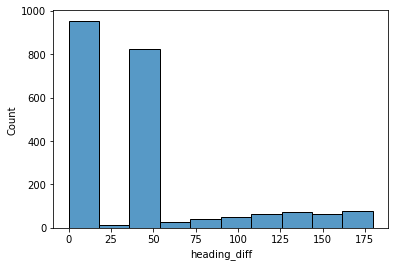

In [87]:
sns.histplot(alldf.query('pred_port == 138')['heading_diff'], bins=10)